# 水平集函数的初始化

## （1）水平集函数初始化为符号距离函数
  1. 定义孔洞
圆形孔洞的界面定义为圆的边界，即 $(x - cx)^2 + (y - cy)^2 = cr^2$，其中 $(cx,cy)$ 是圆心，$cr$ 是半径。

  1. 计算距离
计算每个网格点带所有孔洞圆心的欧式距离
$$d_i = \sqrt{(x-cx_i)^2 + (y-cy_i)^2} - cr$$
其中 $i$ 表示第 $i$ 个孔洞。

  3. 构建水平集函数
  $$\Phi(x,y) = \min_id_i(x,y)$$
  其中 $\Phi(x,y)$ 表示水平集网格点 $(x,y)$ 的水平集函数值，其中 $\Phi$ 满足
$$
\begin{cases}
\Phi(x,y) = 0 &在圆边界上\\
\Phi(x,y) > 0 &在圆外\\
\Phi(x,y) < 0 &在圆内
\end{cases}$$

## （2）水平集函数的边界处理：

  1. 边界处的水平集函数设置为很小的负数，确保了边界始终被视为非材料区域，有助于避免优化过程中生成不必要的孔洞。

## （3）水平集函数值从水平集网格的节点投影到有限元网格的节点：

  1. 找到四个最近邻的原始数据点，并使用它们的值通过三次多项式构造一个局部插值函数，然后，使用此局部插值函数评估目标点的函数值，也就是说将水平集函数在水平集节点的值插值到有限元节点上。通过这种投影，可以确保在有限元分析中，每个单元的物理性质（如密度）与其位置相关的水平集函数值相对应，从而使设计更新更加准确。


In [1]:
import numpy as np

# 测试参数
domain_width = 2 # 设计区域的宽度
domain_hight = 1 # 设计区域的高度
nelx = 8 # x 方向的单元数
nely = 4 # y 方向的单元数
ew = domain_width / nelx # 单元的宽度
eh = domain_hight / nely # 单元的高度

def init_lsf(mesh):
    '''
    初始化设计区域内的水平集函数，以分布初始孔洞的符号距离函数表示.

    该函数通过定义一系列圆形孔洞，并计算网格点到这些孔洞边界的最短距离，来初始化水平集函数
    水平集函数在孔洞内部为负，在孔洞外部为正.

    Parameters:
    - mesh (object): 初始的水平集网格.

    Returns:
    - ls_Phi ( ndarray - (ls_NN, ) ): 初始的水平集函数.

    '''
    ls_node = mesh.entity('node')
    ls_x = ls_node[:, 0]
    ls_y = ls_node[:, 1]

    # 定义初始孔洞的圆心
    cx = domain_width/200 * np.array([33.33,  100,  166.67,   0,    66.67,  133.33,
                                        200,  33.33,  100,   166.67,   0,    66.67,
                                        133.33,  200,  33.33,   100,   166.67], dtype=np.float64)
    cy = domain_hight/100 * np.array([0,  0,  0,   25,  25, 25,
                                        25, 50, 50,  50,  75, 75,
                                        75, 75, 100, 100, 100], dtype=np.float64)
    # 定义初始孔洞的半径
    cr = domain_hight / 10

    # 计算每个网格点与所有圆心的欧式距离
    tmpPhi = np.sqrt((ls_x[:, None] - cx)**2 + (ls_y[:, None] - cy)**2) - cr # (ls_NN, 17)
    print("tmpPhi:", tmpPhi.shape, "\n", tmpPhi)

    # 对于每个节点，取其到所有圆心距离的最大负值，以确保节点若在任一孔洞内部，则其水平集函数值为负
    ls_Phi = np.min(tmpPhi, axis=1)

    return ls_Phi

from fealpy.mesh import UniformMesh2d
ls_domain = [-ew/2, domain_width+ew/2, -eh/2, domain_hight+eh/2]
ls_mesh = UniformMesh2d(extent=(0, nelx+1, 0, nely+1), 
                    h=(ew, eh), origin=(ls_domain[0], ls_domain[2]))
ls_NC = ls_mesh.number_of_cells()
print("ls_NC:", ls_NC)
ls_NN = ls_mesh.number_of_nodes()
print("ls_NN:", ls_NN)
ls_node = ls_mesh.entity('node')
ls_x = ls_node[:, 0]
ls_y = ls_node[:, 1]


## Step 1：初始化水平集函数为符号距离函数
ls_Phi = init_lsf(mesh = ls_mesh)
print("ls_Phi:", ls_Phi.shape, "\n", ls_Phi.round(3))

# Setp 2：边界条件处理
is_bd_node = ls_mesh.ds.boundary_node_flag()
print("is_bd_node:", is_bd_node.shape, "\n", is_bd_node)
ls_Phi_boundary = ls_Phi
ls_Phi_boundary[is_bd_node] = -1e-6
print("ls_Phi_boundary:", ls_Phi_boundary.shape, "\n", ls_Phi_boundary.round(3))

# Step 3：水平集函数值 Phi 从水平集节点投影到有限元节点
fe_domain = [0, domain_width, 0, domain_hight]
fe_mesh = UniformMesh2d(extent=(0, nelx, 0, nely), 
                    h=(ew, eh), origin=(fe_domain[0], fe_domain[2]))
fe_NC = fe_mesh.number_of_cells()
print("fe_NC:", fe_NC)
fe_NN = fe_mesh.number_of_nodes()
print("fe_NN:", fe_NN)
fe_node = fe_mesh.entity('node')
fe_x = fe_node[:, 0]
fe_y = fe_node[:, 1]

from scipy.interpolate import griddata
fe_Phi = griddata((ls_x, ls_y), ls_Phi, (fe_x, fe_y), method='cubic')
print("fe_Phi0:", fe_Phi.shape, "\n", fe_Phi.round(3))


ls_NC: 45
ls_NN: 60
tmpPhi: (60, 17) 
 [[0.37504094 1.03192314 1.69605509 ... 1.11476907 1.49099026 2.01561194]
 [0.37504094 1.03192314 1.69605509 ... 0.887757   1.32521928 1.8939443 ]
 [0.4921688  1.08585412 1.73052285 ... 0.67502509 1.18695377 1.79758106]
 ...
 [1.79758106 1.18695377 0.67502509 ... 1.73052285 1.08585412 0.4921688 ]
 [1.8939443  1.32521928 0.887757   ... 1.69605509 1.03192314 0.37504094]
 [2.01561194 1.49099026 1.11476907 ... 1.69605509 1.03192314 0.37504094]]
ls_Phi: (60,) 
 [0.295 0.077 0.077 0.077 0.077 0.295 0.143 0.077 0.077 0.077 0.077 0.143
 0.032 0.032 0.032 0.032 0.032 0.032 0.217 0.032 0.032 0.032 0.032 0.217
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.217 0.032 0.032 0.032 0.032 0.217 0.032 0.032 0.032 0.032 0.032 0.032
 0.143 0.077 0.077 0.077 0.077 0.143 0.295 0.077 0.077 0.077 0.077 0.295]
is_bd_node: (60,) 
 [ True  True  True  True  True  True  True False False False False  True
  True False False False False  True  True

# 水平集函数的重置化

## （1）求解重置化方程
    
1. 时间步长取为：

$$\Delta{t} = \frac{1}{2}\frac{\Delta_{\min}}{\max~\big|(\mathrm{sign}(\Phi_n)_{ij}\big|},\quad\Delta_{\min} = \min(\Delta{x},\Delta{y})$$
    
2. 数值计算时可以通过磨光：
$$\mathrm{sign}(\Phi)=\frac{\Phi}{\sqrt{\Phi^2+|\nabla\Phi|^2(\Delta x)^2}}$$
其中 $\nabla\Phi$ 采用中心差分近似，$D_{ij}^{cx}$ 和 $D_{ij}^{cy}$ 分别是两个维度中的中心差分算子。

3. 计算格式：
$$\Phi_{ij}^{n+1} = \Phi_{ij}^n - \Delta{t}\bigg(\max\big(\mathrm{sign}(\Phi_{ij}^n),0\big)\nabla^{+} + \min\big(\mathrm{sign}(\Phi_{ij}^n),0\big)\nabla^{-} - \mathrm{sign}(\Phi_{ij}^n)\bigg)$$
其中
$$\nabla^{+} = \big[\max(D_{ij}^{-x},0)^2 + \min(D_{ij}^{+x},0)^2 + \max(D_{ij}^{-y},0)^2 + \min(D_{ij}^{+y},0)^2\big]^{1/2}$$
$$\nabla^{-} = \big[\max(D_{ij}^{+x},0)^2 + \min(D_{ij}^{-x},0)^2 + \max(D_{ij}^{+y},0)^2 + \min(D_{ij}^{-y},0)^2\big]^{1/2}$$
这里，$\Delta{t}$ 是时间步长，$D_{ij}^{\pm{x}}$ 和 $D_{ij}^{\pm{y}}$ 分别是 $\bm{x}\in\mathbb{R}^2$ 的两个维度中的向前和向后差分算子。

## （2）水平集函数值从水平集网格的节点投影到有限元网格的节点：

  1. 找到四个最近邻的原始数据点，并使用它们的值通过三次多项式构造一个局部插值函数，然后，使用此局部插值函数评估目标点的函数值，也就是说将水平集函数在水平集节点的值插值到有限元节点上。通过这种投影，可以确保在有限元分析中，每个单元的物理性质（如密度）与其位置相关的水平集函数值相对应，从而使设计更新更加准确。

In [10]:
def upwind_diff(phi, d, direction):
    """
    使用迎风格式计算向前和向后有限差分.

    Parameters:
    - phi ( ndarray - (nely+2, nlex+2) ): 水平集函数在水平集网格点上的值;
    - d (float): x 或 y 方向上相邻网格的间距, 取决于 'direction' 参数;
    - direction (str): 'x': 沿 x 方向计算差分, 'y': 表示沿 y 方向计算差分.

    Returns:
    - back_diff ( ndarray - (nely+2, nlex+2) ): 向后差分矩阵: ( phi(i, j) - phi(i-1, j) ) / dx
                            或 ( phi(i, j) - phi(i, j-1) ) / dx, 取决于 'direction'.
    - fawd_diff ( ndarray - (nely+2, nlex+2) ): 向前差分矩阵: ( phi(i+1, j) - phi(i, j) ) / dx
                            或 ( phi(i, j+1) - phi(i, j) ) / dx, 取决于 'direction'.
    """

    # 根据指定的方向计算后向和前向差分
    if direction == 'x':
        x_minus_1 = np.roll(phi, 1, axis=1) # x 方向向右位移
        x_plus_1 = np.roll(phi, -1, axis=1) # x 方向向左位移
        dx = d
        back_diff = (phi - x_minus_1) / dx
        fawd_diff = (x_plus_1 - phi) / dx
    elif direction == 'y':
        y_minus_1 = np.roll(phi, 1, axis=0) # y 方向向下位移
        y_plus_1 = np.roll(phi, -1, axis=0) # y 方向向上位移
        dy = d
        back_diff = (phi - y_minus_1) / dy
        fawd_diff = (y_plus_1 - phi) / dy
    else:
        raise ValueError("direction 必须是 'x' 或 'y'")
    
    return back_diff, fawd_diff

def reinitialize(phi0, dx, dy, loop_num):
    """ 
    将水平集函数重初始化为符号距离函数.

    Parameters:
    - phi0 ( ndarray - (nely+2, nlex+2) ): 重置化前的水平集界面;
    - dx: 有限元单元的宽度;
    - dy: 有限元单元的高度;
    - loop_num: 重新初始化的时间步数.

    Returns:
    - sign_dist_phi (ndarray - (ls_NN, )): 重置化后的水平集界面.
    """
    for _ in range(loop_num + 1):
        # 水平集函数沿 x 和 y 方向的向前和向后差分算子
        dx_L, dx_R = upwind_diff(phi0, dx, 'x')
        dy_L, dy_R = upwind_diff(phi0, dy, 'y')
        
        # 水平集函数沿 x 和 y 方向的中心差分算子
        dx_C = (dx_L + dx_R) / 2
        dy_C = (dy_L + dy_R) / 2
        
        # sign(Phi) 的数值计算
        signPhi = phi0 / (np.sqrt(phi0**2 + (dx_C**2 + dy_C**2) * dx**2) + np.finfo(float).eps)

        # CFL 时间步长
        detT = 0.5 * min(dx, dy) / np.max(np.abs(signPhi))
        
        grad_plus = np.sqrt(np.maximum(dx_L, 0)**2 + np.minimum(dx_R, 0)**2 +
                            np.maximum(dy_L, 0)**2 + np.minimum(dy_R, 0)**2)
        grad_minus = np.sqrt(np.minimum(dx_L, 0)**2 + np.maximum(dx_R, 0)**2 +
                                np.minimum(dy_L, 0)**2 + np.maximum(dy_R, 0)**2)

        phi0 = phi0 - detT * \
            (np.maximum(signPhi, 0)*grad_plus + np.minimum(signPhi, 0)*grad_minus - signPhi)

    sign_dist_phi = phi0.flatten('F')

    return sign_dist_phi

ls_Phi = reinitialize(phi0=ls_Phi.reshape(nelx+2, nely+2).T, 
                    dx=ew, dy=eh, loop_num=50)
print("ls_Phi:", ls_Phi.shape, "\n", ls_Phi.round(3))


ls_Phi: (60,) 
 [18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798
 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798
 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798
 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798
 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798
 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798 18.798]


In [14]:
from fealpy.decorator import cartesian

# 测试参数
domain_width = 2 # 设计区域的宽度
domain_hight = 1 # 设计区域的高度
nelx = 40 # x 方向的单元数
nely = 20 # y 方向的单元数
ew = domain_width / nelx # 单元的宽度
eh = domain_hight / nely # 单元的高度

# 非符号距离函数的水平集函数
@cartesian
def phi_nsd(p):
    x = p[..., 0]
    y = p[..., 1]
    val = (x - 0.5)**2 + (y - 0.75)**2 - 0.0225

    return val

# 符号距离函数的水平集函数
@cartesian
def phi_sd(p):
    x = p[..., 0]
    y = p[..., 1]
    val = np.sqrt((x - 0.5)**2 + (y - 0.75)**2) - 0.15

    return val
from fealpy.mesh import UniformMesh2d
ls_domain = [-ew/2, domain_width+ew/2, -eh/2, domain_hight+eh/2]
ls_mesh = UniformMesh2d(extent=(0, nelx+1, 0, nely+1), 
                    h=(ew, eh), origin=(ls_domain[0], ls_domain[2]))
ls_NC = ls_mesh.number_of_cells()
print("ls_NC:", ls_NC)
ls_NN = ls_mesh.number_of_nodes()
print("ls_NN:", ls_NN)
ls_node = ls_mesh.entity('node')
print("ls_node:", ls_node)

phi_nsd_interpolate = phi_nsd(ls_node)
print("phi_nsd_interpolate:", phi_nsd_interpolate.shape, "\n", phi_nsd_interpolate.round(3))

phi_sd_interpolate = phi_sd(ls_node)
print("phi_sd_interpolate:", phi_sd_interpolate.shape, "\n", phi_sd_interpolate.round(3))

ls_Phi = reinitialize(phi0=phi_nsd_interpolate.reshape(nelx+2, nely+2).T, 
                    dx=ew, dy=eh, loop_num=50)
print("ls_Phi:", ls_Phi.shape, "\n", ls_Phi.round(3))

import os
visualization_dir = 'visualization/'
os.makedirs(visualization_dir, exist_ok=True)

fname = os.path.join(visualization_dir, 'test_wang.vts')
ls_mesh.to_vtk(filename=fname, 
                celldata={'phi_nsd': phi_nsd_interpolate,
                          'phi_sd': phi_sd_interpolate,
                          'lsf': ls_Phi.flatten('F')})

ls_NC: 861
ls_NN: 924
ls_node: [[-0.025 -0.025]
 [-0.025  0.025]
 [-0.025  0.075]
 ...
 [ 2.025  0.925]
 [ 2.025  0.975]
 [ 2.025  1.025]]
phi_nsd_interpolate: (924,) 
 [ 8.540e-01  7.790e-01  7.090e-01  6.440e-01  5.840e-01  5.290e-01
  4.790e-01  4.340e-01  3.940e-01  3.590e-01  3.290e-01  3.040e-01
  2.840e-01  2.690e-01  2.590e-01  2.540e-01  2.540e-01  2.590e-01
  2.690e-01  2.840e-01  3.040e-01  3.290e-01  8.040e-01  7.290e-01
  6.590e-01  5.940e-01  5.340e-01  4.790e-01  4.290e-01  3.840e-01
  3.440e-01  3.090e-01  2.790e-01  2.540e-01  2.340e-01  2.190e-01
  2.090e-01  2.040e-01  2.040e-01  2.090e-01  2.190e-01  2.340e-01
  2.540e-01  2.790e-01  7.590e-01  6.840e-01  6.140e-01  5.490e-01
  4.890e-01  4.340e-01  3.840e-01  3.390e-01  2.990e-01  2.640e-01
  2.340e-01  2.090e-01  1.890e-01  1.740e-01  1.640e-01  1.590e-01
  1.590e-01  1.640e-01  1.740e-01  1.890e-01  2.090e-01  2.340e-01
  7.190e-01  6.440e-01  5.740e-01  5.090e-01  4.490e-01  3.940e-01
  3.440e-01  2.990e-01  2.5

2024-04-27 09:44:15.421 ( 198.047s) [        98A63000]         vtkDataSet.cxx:694   WARN| vtkStructuredGrid (0x55ba79b61570): Cell array phi_nsd with 1 components, has 924 tuples but there are only 861 cells
2024-04-27 09:44:15.421 ( 198.047s) [        98A63000]         vtkDataSet.cxx:694   WARN| vtkStructuredGrid (0x55ba79b61570): Cell array phi_sd with 1 components, has 924 tuples but there are only 861 cells
2024-04-27 09:44:15.421 ( 198.047s) [        98A63000]         vtkDataSet.cxx:694   WARN| vtkStructuredGrid (0x55ba79b61570): Cell array lsf with 1 components, has 924 tuples but there are only 861 cells


'visualization/test_wang.vts'

# 可视化节点水平集函数

In [17]:
import numpy as np

# 测试参数
domain_width = 2 # 设计区域的宽度
domain_hight = 1 # 设计区域的高度
nelx = 40 # x 方向的单元数
nely = 20 # y 方向的单元数
ew = domain_width / nelx # 单元的宽度
eh = domain_hight / nely # 单元的高度

def init_lsf(mesh):
    '''
    初始化设计区域内的水平集函数，以分布初始孔洞的符号距离函数表示.

    该函数通过定义一系列圆形孔洞，并计算网格点到这些孔洞边界的最短距离，来初始化水平集函数
    水平集函数在孔洞内部为负，在孔洞外部为正.

    Parameters:
    - mesh (object): 初始的水平集网格.

    Returns:
    - ls_Phi ( ndarray - (ls_NN, ) ): 初始的水平集函数.

    '''
    ls_node = mesh.entity('node')
    ls_x = ls_node[:, 0]
    ls_y = ls_node[:, 1]

    # 定义初始孔洞的圆心
    cx = domain_width/200 * np.array([33.33,  100,  166.67,   0,    66.67,  133.33,
                                        200,  33.33,  100,   166.67,   0,    66.67,
                                        133.33,  200,  33.33,   100,   166.67], dtype=np.float64)
    cy = domain_hight/100 * np.array([0,  0,  0,   25,  25, 25,
                                        25, 50, 50,  50,  75, 75,
                                        75, 75, 100, 100, 100], dtype=np.float64)
    # 定义初始孔洞的半径
    cr = domain_hight / 10

    # 计算每个网格点与所有圆心的欧式距离
    tmpPhi = np.sqrt((ls_x[:, None] - cx)**2 + (ls_y[:, None] - cy)**2) - cr # (ls_NN, 17)

    # 对于每个节点，取其到所有圆心距离的最大负值，以确保节点若在任一孔洞内部，则其水平集函数值为负
    ls_Phi = np.min(tmpPhi, axis=1)

    return ls_Phi

from fealpy.mesh import UniformMesh2d
ls_domain = [-ew/2, domain_width+ew/2, -eh/2, domain_hight+eh/2]
ls_mesh = UniformMesh2d(extent=(0, nelx+1, 0, nely+1), 
                    h=(ew, eh), origin=(ls_domain[0], ls_domain[2]))
ls_NC = ls_mesh.number_of_cells()
print("ls_NC:", ls_NC)
ls_NN = ls_mesh.number_of_nodes()
print("ls_NN:", ls_NN)
ls_node = ls_mesh.entity('node')
ls_x = ls_node[:, 0]
ls_y = ls_node[:, 1]

## Step 1：初始化水平集函数为符号距离函数
ls_Phi = init_lsf(mesh = ls_mesh)
print("ls_Phi:", ls_Phi.shape, "\n", ls_Phi.round(3))

# Setp 2：边界条件处理
is_bd_node = ls_mesh.ds.boundary_node_flag()
ls_Phi_boundary = ls_Phi
ls_Phi_boundary[is_bd_node] = -1e-6
print("ls_Phi_boundary:", ls_Phi_boundary.shape, "\n", ls_Phi_boundary.round(3))

# Step 3：水平集函数值 Phi 从水平集节点投影到有限元节点
fe_domain = [0, domain_width, 0, domain_hight]
fe_mesh = UniformMesh2d(extent=(0, nelx, 0, nely), 
                    h=(ew, eh), origin=(fe_domain[0], fe_domain[2]))
fe_NC = fe_mesh.number_of_cells()
print("fe_NC:", fe_NC)
fe_NN = fe_mesh.number_of_nodes()
print("fe_NN:", fe_NN)
fe_node = fe_mesh.entity('node')
fe_x = fe_node[:, 0]
fe_y = fe_node[:, 1]

from scipy.interpolate import griddata
fe_Phi = griddata((ls_x, ls_y), ls_Phi, (fe_x, fe_y), method='cubic')
print("fe_Phi:", fe_Phi.shape, "\n", fe_Phi.round(3))

import os
visualization_dir = 'visualization/'
os.makedirs(visualization_dir, exist_ok=True)
fname = os.path.join(visualization_dir, 'wang.vts')
fe_mesh.to_vtk(filename=fname, 
                nodedata={'fe_Phi': fe_Phi.flatten('F')})

ls_NC: 861
ls_NN: 924
ls_Phi: (924,) 
 [ 0.176  0.126  0.077  0.027 -0.021 -0.065 -0.065 -0.021  0.027  0.077
  0.126  0.126  0.077  0.027 -0.021 -0.065 -0.065 -0.021  0.027  0.077
  0.126  0.176  0.176  0.126  0.077  0.027 -0.021 -0.065 -0.065 -0.021
  0.027  0.077  0.126  0.126  0.077  0.027 -0.021 -0.065 -0.065 -0.021
  0.027  0.077  0.126  0.176  0.16   0.137  0.09   0.046  0.006 -0.021
 -0.021  0.006  0.046  0.09   0.137  0.137  0.09   0.046  0.006 -0.021
 -0.021  0.006  0.046  0.09   0.137  0.16   0.11   0.11   0.115  0.077
  0.046  0.027  0.027  0.046  0.077  0.115  0.11   0.11   0.115  0.077
  0.046  0.027  0.027  0.046  0.077  0.115  0.11   0.11   0.06   0.06
  0.075  0.102  0.09   0.077  0.077  0.09   0.102  0.075  0.06   0.06
  0.075  0.102  0.09   0.077  0.077  0.09   0.102  0.075  0.06   0.06
  0.011  0.011  0.032  0.065  0.106  0.126  0.126  0.106  0.065  0.032
  0.011  0.011  0.032  0.065  0.106  0.126  0.126  0.106  0.065  0.032
  0.011  0.011 -0.037 -0.037 -0.005  0.03

'visualization/wang.vts'

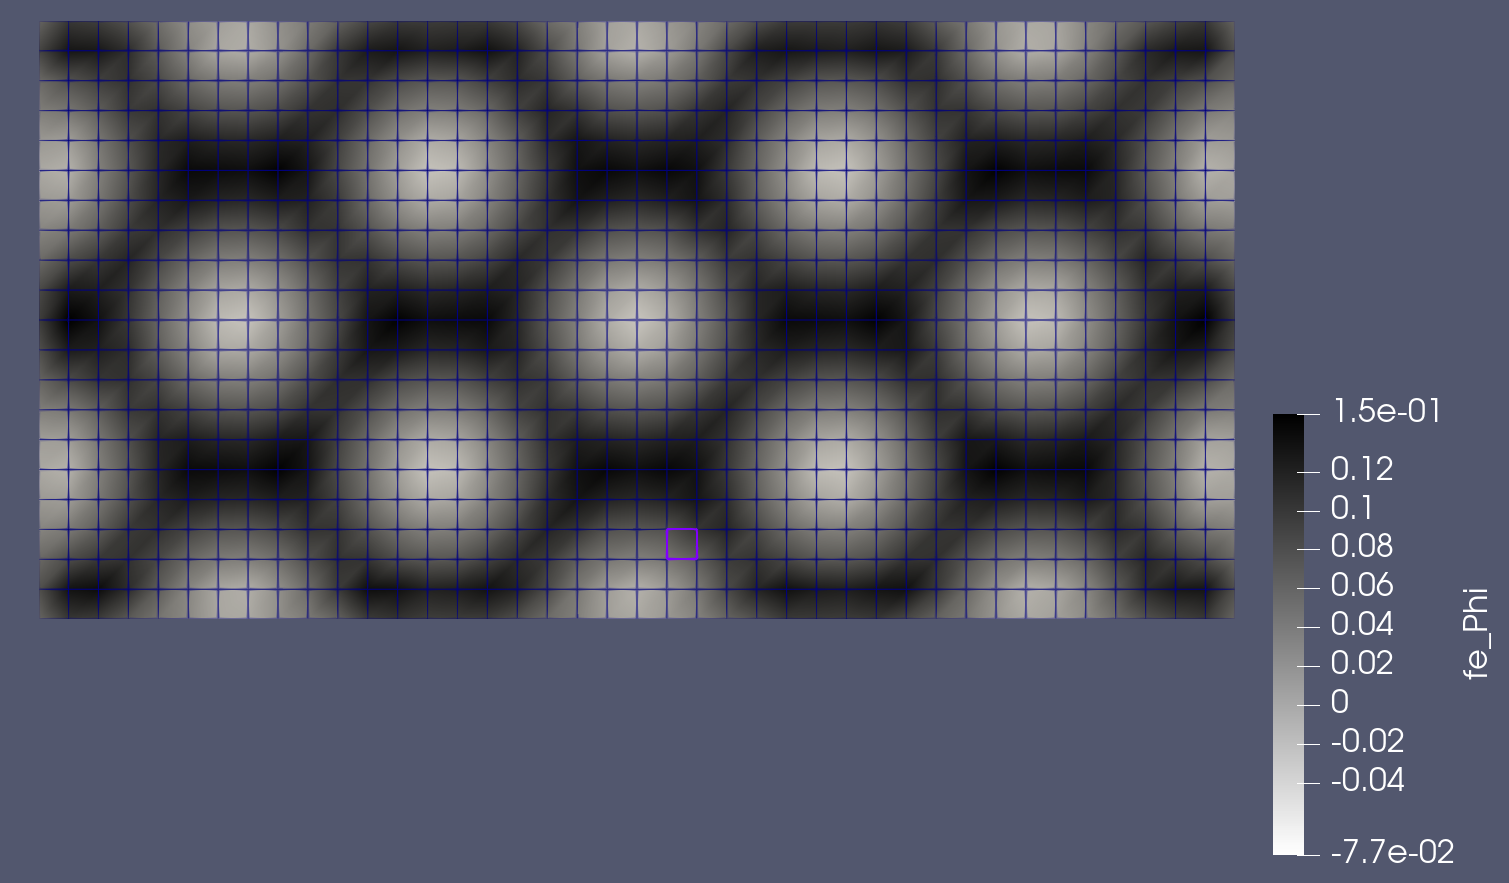

# 水平集函数重置化为符号距离函数